This notebooks contains the fits of the 2PCF multipoles measured by Elisa Lentini. 
The code is by Edoardo Maragliano, but relies on some packages and modules by other people:
- BAOFit is a module by E. Sarpa. E. Maragliano contributed to development of the MCMC. 
- LE3_GC_ProductReader is a package by A. Veropalumbo, designed to read the outputs of Euclid's code for the measurements of the 2PCF. 

In [1]:
import sys
sys.path.append('/home/emaragliano/Work/Projects/BAOFit_BOSS')

In [2]:
import BAOFit.Fit as Fit
import BAOFit.utils as utils
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
import os
import pandas as pd

In [3]:
import sys
sys.path.append('/home/emaragliano/Work/Projects/LE3_GC_ProductReader-main')

In [4]:
import LE3_GC_ProductReader as pr

In [5]:
from scipy.special import eval_legendre

Define a function to convert the 2D 2PCF to its multipoles

In [6]:
def multipole_from_xi2D(xi2D, mu, l=0):
    """
    
    Parameters
    ----------
    xi2D : 2D array
        2D correlation function.
    mu : 2D array
        2D array of mu values.
    l : int
        Multipole order.
        
    Returns
    -------
        array
        Multipole.
        
        """
    multipole = []
    dmu=mu[0][1]-mu[0][0]                        ## measure of the mu bin assuming dmu is constant forall r, mu
    for i in range(0, len(xi2D)):
        P_l=eval_legendre(l,mu[i,:])   
        appo=np.array(xi2D[i]*P_l)                   ##the product is element-wise
        multipole.append(appo)
    multipole = 0.5*(2*l+1)*dmu*np.array(multipole).sum(axis=1)     

    return np.array(multipole)

define a fiducial cosmology

In [7]:
cosmo = utils.DefaultCosmology()
cosmo['Omega_m'] = 0.31
cosmo['Omega_L'] = 0.69
cosmo['Omega_b'] = 0.048
cosmo['hubble'] = 0.676
cosmo['n_s'] = 0.97
cosmo['z'] = np.array([0.38])
cosmo['bias'] = np.array([2.0])

## Fit Elisa pre-rec multipoles

load 2pcf measured by elisa

In [8]:
north_2pcf_elisa_z3 = 'EUC_LE3_GCL_2PCF_BOSS_NORTH_high_totfkp_Correlation_AUTO_2DPOL_5D874710C7E3_20240710T162004.0Z.xml'
north_2pcf_elisa_z3 = os.path.join('/farmdisk1/lentini/Work/Project/xi/BOSS_North/high', north_2pcf_elisa_z3)

In [9]:
north_2pcf_elisa_z1 = 'EUC_LE3_GCL_2PCF_BOSS_NORTH_low_totfkp_Correlation_AUTO_2DPOL_B0406027C0F8_20240710T161910.0Z.xml'
north_2pcf_elisa_z1 = os.path.join('/farmdisk1/lentini/Work/Project/xi/BOSS_North/low', north_2pcf_elisa_z1)

In [10]:
south_2pcf_elisa_z3 = 'EUC_LE3_GCL_2PCF_BOSS_SOUTH_high_totfkp_Correlation_AUTO_2DPOL_5A8851860C82_20240715T115530.0Z.xml'
south_2pcf_elisa_z3 = os.path.join('/farmdisk1/lentini/Work/Project/xi/BOSS_South/high', south_2pcf_elisa_z3)

In [11]:
south_2pcf_elisa_z1 = 'EUC_LE3_GCL_2PCF_BOSS_SOUTH_low_totfkp_Correlation_AUTO_2DPOL_7D4740367B95_20240715T115701.0Z.xml'
south_2pcf_elisa_z1 = os.path.join('/farmdisk1/lentini/Work/Project/xi/BOSS_South/low', south_2pcf_elisa_z1)

In [12]:
z1_N = pr.DpdLE3GCReader()
z3_N = pr.DpdLE3GCReader()
z1_S = pr.DpdLE3GCReader()
z3_S = pr.DpdLE3GCReader()

In [13]:
z1_N.parse_xml(north_2pcf_elisa_z1)
z3_N.parse_xml(north_2pcf_elisa_z3)
z1_S.parse_xml(south_2pcf_elisa_z1)
z3_S.parse_xml(south_2pcf_elisa_z3)

In [14]:
z1_N.read_tables()
z3_N.read_tables()
z1_S.read_tables()
z3_S.read_tables()

In [15]:
readers_dict = {'z1_N': z1_N, 'z3_N': z3_N, 'z1_S': z1_S, 'z3_S': z3_S}

In [16]:
elisa_dict = {}

In [17]:
for zbin in ['z1', 'z3']:
    for emisph in ['N', 'S']:
        for xi_l in ['XI0', 'XI2', 'XI4']:
            elisa_dict[zbin, emisph, 'r'] = np.array(readers_dict[zbin + '_' + emisph].CorrelationMultipole.table['SCALE'])
            elisa_dict[zbin, emisph, xi_l] = np.array(readers_dict[zbin + '_' + emisph].CorrelationMultipole.table[xi_l])

        
        elisa_dict[zbin, emisph, 'bin1num'] = readers_dict[zbin + '_' + emisph].Pairs.header['BIN1NUM']
        elisa_dict[zbin, emisph, 'bin2num'] = readers_dict[zbin + '_' + emisph].Pairs.header['BIN2NUM']
        elisa_dict[zbin, emisph, 'RR'] = np.array(readers_dict[zbin + '_' + emisph].Pairs.table["RR"]).reshape(elisa_dict[zbin, emisph, 'bin1num'], elisa_dict[zbin, emisph, 'bin2num'])
        elisa_dict[zbin, emisph, 'XI2D'] = np.array(readers_dict[zbin + '_' + emisph].Correlation.table['XI']).reshape(elisa_dict[zbin, emisph, 'bin1num'], elisa_dict[zbin, emisph, 'bin2num'])
        elisa_dict[zbin, emisph, 'mu'] = np.array(readers_dict[zbin + '_' + emisph].Correlation.table['SCALE_2D']).reshape(elisa_dict[zbin, emisph, 'bin1num'], elisa_dict[zbin, emisph, 'bin2num'])


merge xi from north and south, weighting on $RR$

In [18]:
xi_z1 = (elisa_dict['z1', 'N', 'XI2D']* elisa_dict['z1', 'N', 'RR']+elisa_dict['z1', 'S', 'XI2D']*elisa_dict['z1', 'S', 'RR'])/( elisa_dict['z1', 'N', 'RR']+elisa_dict['z1', 'S', 'RR'])

In [19]:
xi_z3 = (elisa_dict['z3', 'N', 'XI2D']* elisa_dict['z3', 'N', 'RR']+elisa_dict['z3', 'S', 'XI2D']*elisa_dict['z3', 'S', 'RR'])/( elisa_dict['z3', 'N', 'RR']+elisa_dict['z3', 'S', 'RR'])

In [20]:
elisa_dict['z1', 'N', 'bin1num'], elisa_dict['z1', 'N', 'bin2num']

(40, 20)

In [21]:
r = elisa_dict['z1', 'N', 'r']

compute the multipoles for the xi N+S

In [22]:
elisa_multipoles_z1 = np.ones((3, len(r)))
elisa_multipoles_z1[0,:] = multipole_from_xi2D(xi_z1, elisa_dict['z1', 'N', 'mu'], l=0)
elisa_multipoles_z1[1,:] = multipole_from_xi2D(xi_z1, elisa_dict['z1', 'N', 'mu'], l=2)
elisa_multipoles_z1[2,:] = multipole_from_xi2D(xi_z1, elisa_dict['z1', 'N', 'mu'], l=4)

In [23]:
elisa_multipoles_z3 = np.ones((3, len(r)))
elisa_multipoles_z3[0,:] = multipole_from_xi2D(xi_z3, elisa_dict['z3', 'N', 'mu'], l=0)
elisa_multipoles_z3[1,:] = multipole_from_xi2D(xi_z3, elisa_dict['z3', 'N', 'mu'], l=2)
elisa_multipoles_z3[2,:] = multipole_from_xi2D(xi_z3, elisa_dict['z3', 'N', 'mu'], l=4)

read claudio covariance

In [24]:
cov_z1_C = np.load(os.path.join('/farmdisk1/lentini/Work/Project/Covariance_matrix', 'cov_xi_z1.npy'))

In [25]:
cov_z3_C = np.load(os.path.join('/farmdisk1/lentini/Work/Project/Covariance_matrix', 'cov_xi_z3.npy'))

In [26]:
cov_z1_C.shape

(80, 80)

the covariance only contains mon and quad. my code also assumes the hexadecupole is there -> pad the cov with 0 and do not use the hexadecupole setting ellemax = 2

In [27]:
ext_cov_claudio_z1 = np.zeros((len(r)*3, len(r)*3))
ext_cov_claudio_z3 = np.zeros((len(r)*3, len(r)*3))

In [28]:
np.shape(ext_cov_claudio_z1)

(120, 120)

In [29]:
for i in range(cov_z1_C.shape[0]):
    for j in range(cov_z1_C.shape[1]):
        ext_cov_claudio_z1[i,j] = cov_z1_C[i,j]

for i in range(cov_z3_C.shape[0]):
    for j in range(cov_z3_C.shape[1]):
        ext_cov_claudio_z3[i,j] = cov_z3_C[i,j]

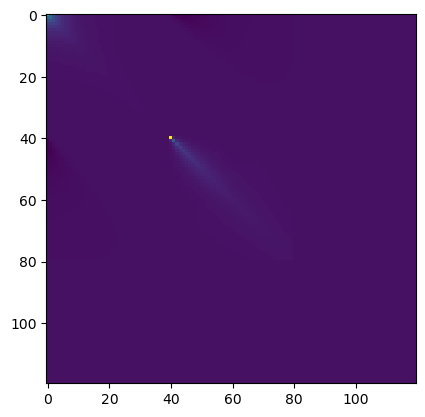

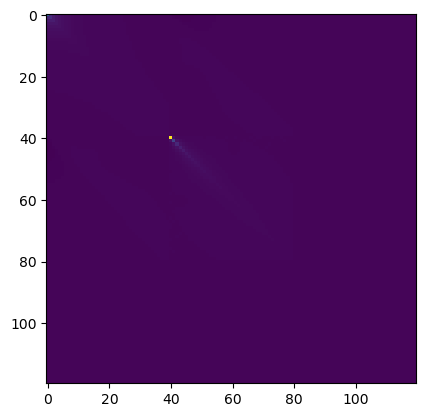

In [30]:
plt.imshow(ext_cov_claudio_z1)
plt.show()
plt.imshow(ext_cov_claudio_z3)

# Fit to the measurements

The model is pheneomenological, as in Ross et al (2016)

$P(k,\mu)=C^2(k,\mu,\Sigma_s) \left(( P_\text{lin}-P_\text{nw})e^{-k^2\sigma_v^2}+P_\text{nw} \right)$ where $\sigma_v^2$ is the anisotropic damping defined as

 $\sigma_v^2 = (1-\mu^2)\Sigma_\perp^2/2+\mu^2\Sigma_\parallel^2/2$ and

 $C(k,\mu, \Sigma_s) = \frac{1+\mu^2\beta(1-S(k))}{1+k^2\mu^2\Sigma_s^2/2}$ where $S(k)$ is a gaussian smoothing kernel with size $\Sigma_r = 15 h^{-1}\text{Mpc}$

 From $P(k,\mu)$ the multipoles of the PS are computed and Hankel transformed to get the multipoles of the 2PCF. They are resummed into the anisotropic 2PCF, to which the AP transformation is applied:
 $\xi(s, \mu) \rightarrow \xi(s', \mu')$.

 Then $\xi(s', \mu')$ is expanded in multipoles.
 
 A polynomial broadband term $a_{l,1}/s^2+a_{l,2}/s+a_{l_3}$ is added at the end to each multipole to absorb any full shape distortion uncorrelated with the BAO signal.

GENERAL NOTE: 
1. iMinuit is not so accurate in estimating the errors. MCMC should be employed. It'd have taken too long.
2. Even using the hexadecupole, $f$ is often not well constrained. The values reported later are not so reliable.

In [43]:
param_names = {
    'alpha_par': r'$\alpha_\parallel$', 
    'alpha_perp': r'$\alpha_\perp$', 
    'bias': 'bias',
    'f': '$f$',
    'Sigma_par': r'$\Sigma_\parallel$',
    'Sigma_perp': r'$\Sigma_\perp$',
    'b00': 'b00',
    'b01': 'b01', 
    'b02': 'b02', 
    'b20': 'b20',
    'b21': 'b21', 
    'b22': 'b22', 
}


## Fit Elisa pre rec measurements

#### Fit BAO z1 pre rec

In [31]:
fit_elisa_xi_z1 = Fit.BestFit(r, elisa_multipoles_z1, ext_cov_claudio_z1, cosmo, space='RedshiftSpace', rectype='', sigma_rec=0, ellemax=2, fit_range=[50, 150])

considering  2  polynomials
fit-range [50, 150]


In [32]:
BF_elisa, BF_err_elisa = fit_elisa_xi_z1.run()

running fit...
modelling ...
shape subcov (40, 40)


/home/emaragliano/miniconda3/lib/python3.11/site-packages/BAOFit/Templates.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_elle[i]=(2.*elles[i]+1.)/2.*np.trapz(xi_mup_rp*Ll[:, None], x=mus, axis=0,dx=mus[1]-mus[0])


Best-fit parameters:
({'alpha_par': 1.0368677969412574, 'alpha_perp': 0.9777825859537266, 'bias': 1.6504780950695646, 'f': 1.5134084323661834, 'Sigma_par': 9.39220287250396, 'Sigma_perp': 2.0748364912481008, 'Sigma_s': 0, 'Sigma_rec': 0}, {'b00': -1.4477309195124932, 'b01': 5.9706987235801865, 'b02': -2.3037563752235894, 'b20': -6.596189984959939, 'b21': 8.970647351708616, 'b22': 10.890964203837173, 'b40': 0.0, 'b41': 0.0, 'b42': 0.0})
Parameter errors:
[ 0.02629943  0.01519624  0.29821139  0.66836419  2.33522415  4.41807103
  2.44580745  5.93898363  3.82917146  5.22693984 11.54640775 13.73701092]
chi2_red:
1.7268478816152053


In [55]:
data = {
    param_names[key]: [BF_elisa[i], BF_err_elisa[i]] for i, key in enumerate(param_names)
}

df_elisa_z1 = pd.DataFrame(data, index=['Best Fit', 'Error'])


In [56]:
df_elisa_z1.round(3)

,$\alpha_\parallel$,$\alpha_\perp$,bias,$f$,$\Sigma_\parallel$,$\Sigma_\perp$,b00,b01,b02,b20,b21,b22
Best Fit,1.037,0.978,1.650,1.513,9.392,2.075,-1.448,5.971,-2.304,-6.596,8.971,10.891
Error,0.026,0.015,0.298,0.668,2.335,4.418,2.446,5.939,3.829,5.227,11.546,13.737


these results are to be compared with Ross et al. 2017, sec 7.2, tab 5. They have the right covariance matrix (actually, two types)
- $\chi^2$/dof is 45/30 = 1.5 pre rec
- $\alpha_\parallel = 1.068 \pm 0.035$
- $\alpha_\perp = 0.982 \pm 0.020$

In [33]:
best_fit_model_z1 = fit_elisa_xi_z1.GetModelBF()

In [104]:
errors_elisa_z1 = np.sqrt(np.diag(cov_z1_C))

In [35]:
errors_elisa_z1.shape

(80,)

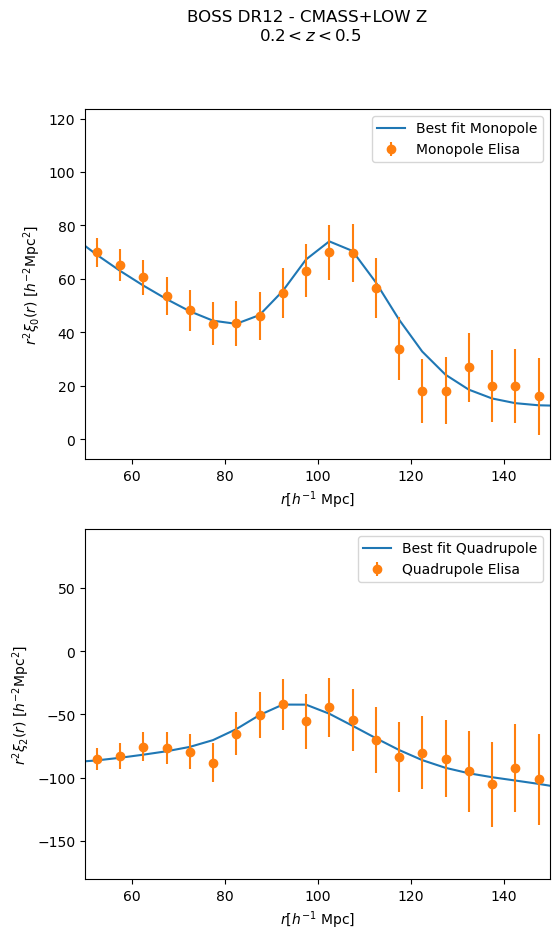

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

ax1.plot(r, r**2*best_fit_model_z1[0], label='Best fit Monopole')
ax1.errorbar(r, r**2*elisa_multipoles_z1[0], yerr=r**2*errors_elisa_z1[:40], fmt='o', label='Monopole Elisa')
ax1.set_ylabel('Monopole')
ax1.legend()
ax1.set_xlabel(r'$r [h^{-1}\ \text{Mpc}]$')
ax1.set_ylabel(r'$r^2\xi_0(r)\ [h^{-2} \text{Mpc}^2]$')
ax1.set_xlim(50, 150)

ax2.plot(r, r**2*best_fit_model_z1[1], label='Best fit Quadrupole')
ax2.errorbar(r, r**2*elisa_multipoles_z1[1], yerr=r**2*errors_elisa_z1[40:], fmt='o', label='Quadrupole Elisa')
ax2.set_xlabel('r')
ax2.set_ylabel('Quadrupole')
ax2.legend()
ax2.set_xlabel(r'$r [h^{-1}\ \text{Mpc}]$')
ax2.set_ylabel(r'$r^2\xi_2(r)\ [h^{-2} \text{Mpc}^2]$')
ax2.set_xlim(50, 150)

plt.legend()
fig.suptitle('BOSS DR12 - CMASS+LOW Z \n$0.2<z<0.5$ pre rec meas by Elisa')
plt.show()


### Fit BAO z3 pre rec

In [57]:
fit_elisa_xi_z3 = Fit.BestFit(r, elisa_multipoles_z3, ext_cov_claudio_z3, cosmo, space='RedshiftSpace', rectype='', sigma_rec=0, ellemax=2, fit_range=[50, 150])

considering  2  polynomials
fit-range [50, 150]


In [58]:
BF_elisa_z3, BF_err_elisa_z3 = fit_elisa_xi_z3.run()

running fit...
modelling ...
shape subcov (40, 40)


/home/emaragliano/miniconda3/lib/python3.11/site-packages/BAOFit/Templates.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_elle[i]=(2.*elles[i]+1.)/2.*np.trapz(xi_mup_rp*Ll[:, None], x=mus, axis=0,dx=mus[1]-mus[0])


Best-fit parameters:
({'alpha_par': 0.9478889483801235, 'alpha_perp': 1.0000966981646167, 'bias': 1.5645337533662975, 'f': 0.48678987846691424, 'Sigma_par': 0.0015295916177749612, 'Sigma_perp': 3.817287182003346, 'Sigma_s': 0, 'Sigma_rec': 0}, {'b00': -0.09177380192710835, 'b01': 0.4192719981831023, 'b02': 1.2330556050145527, 'b20': -0.6795688826925925, 'b21': 1.7776289772612495, 'b22': -3.5136248873903333, 'b40': 0.0, 'b41': 0.0, 'b42': 0.0})
Parameter errors:
[ 0.02313542  0.02054555  0.32550668  0.49743482 12.87934517  4.21111738
  1.94798547  4.73970546  3.04898062  4.26641206  9.58049183  8.82442112]
chi2_red:
0.9646397509840935


In [59]:
data = {
    param_names[key]: [BF_elisa_z3[i], BF_err_elisa_z3[i]] for i, key in enumerate(param_names)
}

df_elisa_z3 = pd.DataFrame(data, index=['Best Fit', 'Error'])

In [63]:
df_elisa_z3.round(3)

,$\alpha_\parallel$,$\alpha_\perp$,bias,$f$,$\Sigma_\parallel$,$\Sigma_\perp$,b00,b01,b02,b20,b21,b22
Best Fit,0.948,1.000,1.565,0.487,0.002,3.817,-0.092,0.419,1.233,-0.680,1.778,-3.514
Error,0.023,0.021,0.326,0.497,12.879,4.211,1.948,4.740,3.049,4.266,9.580,8.824


these results are to be compared with Ross et al. 2017, sec 7.2, tab 5. 
- $\chi^2$/dof is 30/30 = 1.0 pre rec
- $\alpha_\parallel = 0.963 \pm 0.035$
- $\alpha_\perp = 0.999 \pm 0.024$

In [64]:
best_fit_model_z3 = fit_elisa_xi_z3.GetModelBF()

/home/emaragliano/miniconda3/lib/python3.11/site-packages/BAOFit/Templates.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_elle[i]=(2.*elles[i]+1.)/2.*np.trapz(xi_mup_rp*Ll[:, None], x=mus, axis=0,dx=mus[1]-mus[0])


In [65]:
errors_elisa_z3 = np.sqrt(np.diag(cov_z3_C))

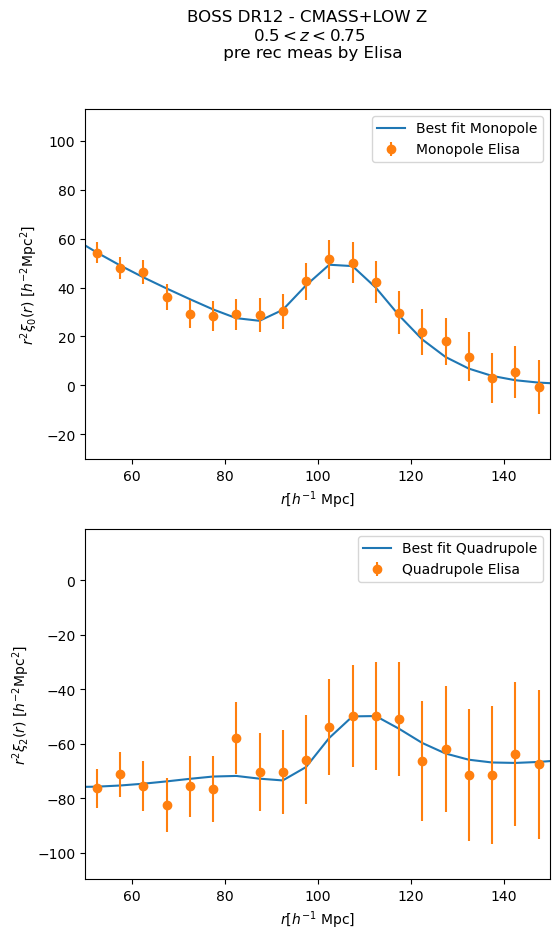

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

ax1.plot(r, r**2*best_fit_model_z3[0], label='Best fit Monopole')
ax1.errorbar(r, r**2*elisa_multipoles_z3[0], yerr=r**2*errors_elisa_z3[:40], fmt='o', label='Monopole Elisa')
ax1.set_ylabel('Monopole')
ax1.legend()
ax1.set_xlabel(r'$r [h^{-1}\ \text{Mpc}]$')
ax1.set_ylabel(r'$r^2\xi_0(r)\ [h^{-2} \text{Mpc}^2]$')
ax1.set_xlim(50, 150)

ax2.plot(r, r**2*best_fit_model_z3[1], label='Best fit Quadrupole')
ax2.errorbar(r, r**2*elisa_multipoles_z3[1], yerr=r**2*errors_elisa_z3[40:], fmt='o', label='Quadrupole Elisa')
ax2.set_xlabel('r')
ax2.set_ylabel('Quadrupole')
ax2.legend()
ax2.set_xlabel(r'$r [h^{-1} \ \text{Mpc}]$')
ax2.set_ylabel(r'$r^2\xi_2(r) \ [h^{-2} \text{Mpc}^2]$')
ax2.set_xlim(50, 150)

plt.legend()
fig.suptitle('BOSS DR12 - CMASS+LOW Z \n$0.5<z<0.75 $ \n pre rec meas by Elisa')
plt.show()


## Fit Ross et al reconstructed multipoles

#### load ross et al xi measures, z1

In [67]:
s_ross, mon_ross, err_mon_ross = np.loadtxt('/home/emaragliano/Work/Projects/myfarm-disk/BossAnalysis/Ross_2016_COMBINEDDR12/Ross_2016_COMBINEDDR12_zbin1_correlation_function_monopole_post_recon_bincent0.dat',usecols=(0,1,2), unpack=True)
s_ross, quad_ross, err_quad_ross = np.loadtxt('/home/emaragliano/Work/Projects/myfarm-disk/BossAnalysis/Ross_2016_COMBINEDDR12/Ross_2016_COMBINEDDR12_zbin1_correlation_function_quadrupole_post_recon_bincent0.dat',usecols=(0,1,2), unpack=True)

In [68]:
xi_multipoles_ross = np.ones((3, len(s_ross)))
xi_multipoles_ross[0, :] = mon_ross
xi_multipoles_ross[1, :] = quad_ross
xi_multipoles_ross[2, :] = 0

In [69]:
cov_ross = np.loadtxt('/home/emaragliano/Work/Projects/myfarm-disk/BossAnalysis/Ross_2016_COMBINEDDR12/Ross_2016_COMBINEDDR12_zbin1_covariance_monoquad_post_recon_bincent0.dat')

In [70]:
ext_cov_ross = np.zeros((len(s_ross)*3, len(s_ross)*3))
for i in range(cov_ross.shape[0]):
    for j in range(cov_ross.shape[1]):
        ext_cov_ross[i,j] = cov_ross[i,j]

In [71]:
ext_cov_ross.shape

(108, 108)

In [72]:
Fit_ross = Fit.BestFit(s_ross, xi_multipoles_ross, ext_cov_ross, cosmo, space='RedshfitSpace', rectype='rec-iso', sigma_rec=15, ellemax=2, fit_range=[50,150])

considering  2  polynomials
fit-range [50, 150]


In [73]:
BF_pars_ross, BF_errs_ross = Fit_ross.run()

running fit...
modelling ...
shape subcov (40, 40)
init guess is,  dict_keys(['alpha_par', 'alpha_perp', 'bias', 'f', 'Sigma_par', 'Sigma_perp', 'Sigma_s', 'Sigma_rec'])
Best-fit parameters:
({'alpha_par': 1.0302918709143025, 'alpha_perp': 0.9821194899789762, 'bias': 1.9841084451592377, 'f': 0, 'Sigma_par': 4.684439878312989, 'Sigma_perp': 2.739897281201096, 'Sigma_s': 0, 'Sigma_rec': 15}, {'b00': -1.2604205490030975, 'b01': 5.347898194926243, 'b02': -3.052243075025081, 'b20': -4.645217445029215, 'b21': 13.257496632635261, 'b22': -6.558194487078131, 'b40': 0.0, 'b41': 0.0, 'b42': 0.0})
Parameter errors:
[2.69675914e-02 7.98130924e-03 1.82586430e-01 2.82302402e+00
 3.13443395e+00 1.97677909e+00 4.71589720e+00 2.98046854e+00
 4.08980776e+00 8.65870328e+00 4.40572100e+00]
chi2_red:
1.4456973534056805


In [82]:
# insert 0 for f: rec-sym fixes it
BF_pars_ross=np.insert(BF_pars_ross, 3, 0)
BF_errs_ross=np.insert(BF_errs_ross, 3, 0)

In [83]:
data = {
    param_names[key]: [BF_pars_ross[i], BF_errs_ross[i]] for i, key in enumerate(param_names)
}

df_ross_z1 = pd.DataFrame(data, index=['Best Fit', 'Error'])

In [85]:
df_ross_z1.round(3)

,$\alpha_\parallel$,$\alpha_\perp$,bias,$f$,$\Sigma_\parallel$,$\Sigma_\perp$,b00,b01,b02,b20,b21,b22
Best Fit,1.030,0.982,1.984,0.0,4.684,2.740,-1.260,5.348,-3.052,-4.645,13.257,-6.558
Error,0.027,0.008,0.183,0.0,2.823,3.134,1.977,4.716,2.980,4.090,8.659,4.406


these results are to be compared with Ross et al. 2017, sec 7.2, tab 5. 
- $\chi^2$/dof is 48/30 = 1.6 
- $\alpha_\parallel = 1.024 \pm 0.024$
- $\alpha_\perp = 0.986 \pm 0.013$

results are very similar to those in the paper. Note that post rec they FIX $\beta=0.4$, $\Sigma_\parallel = 4h^{-1}$ Mpc, $\Sigma_\perp = 2.5h^{-1}$ Mpc. (Ross et al, sec 2.3), while I left them free and found $\Sigma_\parallel = 4.7 \pm 2.8 \ h^{-1}\text{Mpc}$, $\Sigma_\perp = 2.7 \pm 3.1 \ h^{-1} \text{Mpc} $

In [86]:
best_fit_model_z1_ross = Fit_ross.GetModelBF()

/home/emaragliano/miniconda3/lib/python3.11/site-packages/BAOFit/Templates.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_elle[i]=(2.*elles[i]+1.)/2.*np.trapz(xi_mup_rp*Ll[:, None], x=mus, axis=0,dx=mus[1]-mus[0])


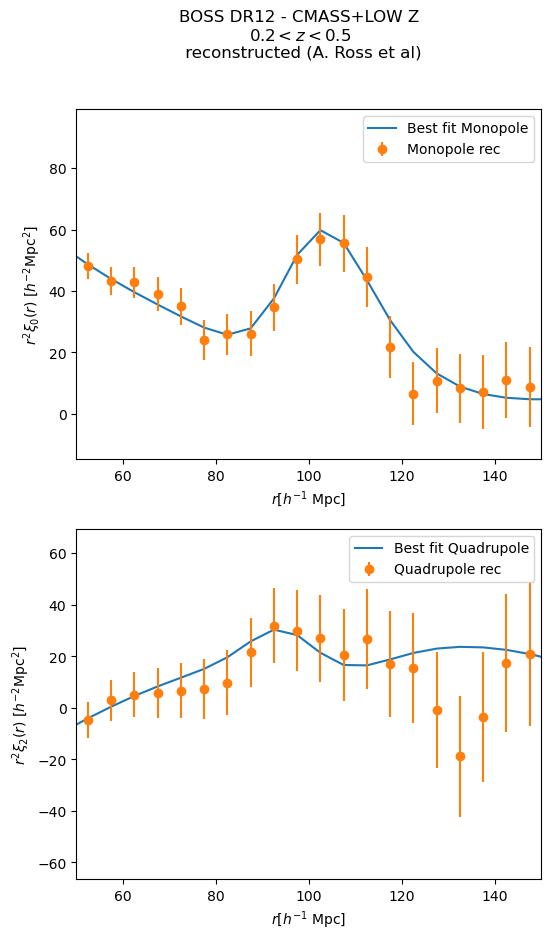

In [87]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

ax1.plot(s_ross, s_ross**2*best_fit_model_z1_ross[0], label='Best fit Monopole')
ax1.errorbar(s_ross, s_ross**2*xi_multipoles_ross[0], yerr=s_ross**2*err_mon_ross, fmt='o', label='Monopole rec')
ax1.set_ylabel('Monopole')
ax1.legend()
ax1.set_xlabel(r'$r [h^{-1}\ \text{Mpc}]$')
ax1.set_ylabel(r'$r^2\xi_0(r)\ [h^{-2} \text{Mpc}^2]$')
ax1.set_xlim(50, 150)

ax2.plot(s_ross, s_ross**2*best_fit_model_z1_ross[1], label='Best fit Quadrupole')
ax2.errorbar(s_ross, s_ross**2*xi_multipoles_ross[1], yerr=s_ross**2*err_quad_ross, fmt='o', label='Quadrupole rec')
ax2.set_xlabel('r')
ax2.set_ylabel('Quadrupole')
ax2.legend()
ax2.set_xlabel(r'$r [h^{-1} \ \text{Mpc}]$')
ax2.set_ylabel(r'$r^2\xi_2(r) \ [h^{-2} \text{Mpc}^2]$')
ax2.set_xlim(50, 150)

plt.legend()
fig.suptitle('BOSS DR12 - CMASS+LOW Z \n$0.2<z<0.5$ \n reconstructed (A. Ross et al)')
plt.show()

#### load ross measurements, z3

In [88]:
s_ross_z3, mon_ross_z3, err_mon_ross_z3 = np.loadtxt('/home/emaragliano/Work/Projects/myfarm-disk/BossAnalysis/Ross_2016_COMBINEDDR12/Ross_2016_COMBINEDDR12_zbin3_correlation_function_monopole_post_recon_bincent0.dat',usecols=(0,1,2), unpack=True)
s_ross_z3, quad_ross_z3, err_quad_ross_z3 = np.loadtxt('/home/emaragliano/Work/Projects/myfarm-disk/BossAnalysis/Ross_2016_COMBINEDDR12/Ross_2016_COMBINEDDR12_zbin3_correlation_function_quadrupole_post_recon_bincent0.dat',usecols=(0,1,2), unpack=True)

In [89]:
xi_multipoles_ross_z3 = np.ones((3, len(s_ross_z3)))
xi_multipoles_ross_z3[0, :] = mon_ross_z3
xi_multipoles_ross_z3[1, :] = quad_ross_z3
xi_multipoles_ross_z3[2, :] = 0

In [90]:
cov_ross_z3 = np.loadtxt('/home/emaragliano/Work/Projects/myfarm-disk/BossAnalysis/Ross_2016_COMBINEDDR12/Ross_2016_COMBINEDDR12_zbin3_covariance_monoquad_post_recon_bincent0.dat')

In [91]:
ext_cov_ross_z3 = np.zeros((len(s_ross_z3)*3, len(s_ross_z3)*3))
for i in range(cov_ross_z3.shape[0]):
    for j in range(cov_ross_z3.shape[1]):
        ext_cov_ross_z3[i,j] = cov_ross_z3[i,j]

In [92]:
Fit_ross_z3 = Fit.BestFit(s_ross_z3, xi_multipoles_ross_z3, ext_cov_ross_z3, cosmo, space='RedshfitSpace', rectype='rec-iso', sigma_rec=15, ellemax=2, fit_range=[50,150])

considering  2  polynomials
fit-range [50, 150]


In [93]:
BF_pars_ross_z3, BF_errs_ross_z3 = Fit_ross_z3.run()

running fit...
modelling ...
shape subcov (40, 40)
init guess is,  dict_keys(['alpha_par', 'alpha_perp', 'bias', 'f', 'Sigma_par', 'Sigma_perp', 'Sigma_s', 'Sigma_rec'])
Best-fit parameters:
({'alpha_par': 0.9605417112505198, 'alpha_perp': 0.9893618438540682, 'bias': 1.901238423451042, 'f': 0, 'Sigma_par': 6.736504472553274e-06, 'Sigma_perp': 3.330730715825537, 'Sigma_s': 0, 'Sigma_rec': 15}, {'b00': -1.3788454756355857, 'b01': 7.107067412542734, 'b02': -5.342098907261679, 'b20': -5.49312116087052, 'b21': 15.620712586557085, 'b22': -8.446421092422895, 'b40': 0.0, 'b41': 0.0, 'b42': 0.0})
Parameter errors:
[ 0.01991244  0.01213231  0.14627344 10.11413353  2.23110232  1.71130614
  4.11662468  2.47699215  3.62457224  7.80824315  4.12087934]
chi2_red:
0.9810039778885513


In [94]:
# insert 0 for f: rec-sym fixes it
BF_pars_ross_z3=np.insert(BF_pars_ross_z3, 3, 0)
BF_errs_ross_z3=np.insert(BF_errs_ross_z3, 3, 0)
data = {
    param_names[key]: [BF_pars_ross_z3[i], BF_errs_ross_z3[i]] for i, key in enumerate(param_names)
}

df_ross_z3 = pd.DataFrame(data, index=['Best Fit', 'Error'])
df_ross_z3.round(3)

,$\alpha_\parallel$,$\alpha_\perp$,bias,$f$,$\Sigma_\parallel$,$\Sigma_\perp$,b00,b01,b02,b20,b21,b22
Best Fit,0.961,0.989,1.901,0.0,0.000,3.331,-1.379,7.107,-5.342,-5.493,15.621,-8.446
Error,0.020,0.012,0.146,0.0,10.114,2.231,1.711,4.117,2.477,3.625,7.808,4.121


these results are to be compared with Ross et al. 2017, sec 7.2, tab 5. 
- $\chi^2$/dof is $33/30 \approx  1$ 
- $\alpha_\parallel = 0.962 \pm 0.020$
- $\alpha_\perp = 0.991 \pm 0.015$

In general good agreement. I get a very weird value for $\Sigma_\parallel$, but the error is huge.

In [95]:
best_fit_model_z3_ross = Fit_ross_z3.GetModelBF()

/home/emaragliano/miniconda3/lib/python3.11/site-packages/BAOFit/Templates.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_elle[i]=(2.*elles[i]+1.)/2.*np.trapz(xi_mup_rp*Ll[:, None], x=mus, axis=0,dx=mus[1]-mus[0])


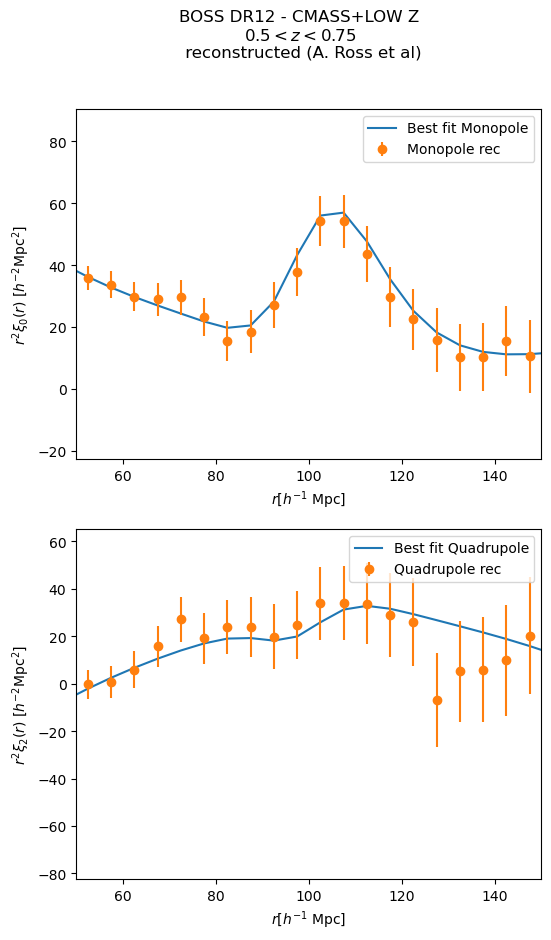

In [96]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

ax1.plot(s_ross, s_ross**2*best_fit_model_z3_ross[0], label='Best fit Monopole')
ax1.errorbar(s_ross, s_ross**2*xi_multipoles_ross_z3[0], yerr=s_ross**2*err_mon_ross_z3, fmt='o', label='Monopole rec')
ax1.set_ylabel('Monopole')
ax1.legend()
ax1.set_xlabel(r'$r [h^{-1}\ \text{Mpc}]$')
ax1.set_ylabel(r'$r^2\xi_0(r)\ [h^{-2} \text{Mpc}^2]$')
ax1.set_xlim(50, 150)

ax2.plot(s_ross, s_ross**2*best_fit_model_z3_ross[1], label='Best fit Quadrupole')
ax2.errorbar(s_ross, s_ross**2*xi_multipoles_ross_z3[1], yerr=s_ross**2*err_quad_ross_z3, fmt='o', label='Quadrupole rec')
ax2.set_xlabel('r')
ax2.set_ylabel('Quadrupole')
ax2.legend()
ax2.set_xlabel(r'$r [h^{-1} \ \text{Mpc}]$')
ax2.set_ylabel(r'$r^2\xi_2(r) \ [h^{-2} \text{Mpc}^2]$')
ax2.set_xlim(50, 150)

plt.legend()
fig.suptitle('BOSS DR12 - CMASS+LOW Z \n$0.5<z<0.75$ \n reconstructed (A. Ross et al)')
plt.show()

## Fit my reconstructed multipoles

### my rec in z1

In [97]:
s, mon, quad, hexad = np.load('/home/emaragliano/Work/Projects/acc_BOSS_analysis/myBOSS_rec_multipoles_z1.npy')

In [98]:
xi_multipoles_rec = np.ones((3, len(s)))
xi_multipoles_rec[0, :] = mon
xi_multipoles_rec[1, :] = quad
xi_multipoles_rec [2, :] = 0

note that I do not have a covariance matrix done by us to fit the reconstructed xi. I am using the same I used to fit the unreconstructed xi. 

In [99]:
Fit_my_rec_z1 = Fit.BestFit(s, xi_multipoles_rec, ext_cov_claudio_z1, cosmo, space='RedshfitSpace', rectype='rec-iso', sigma_rec=15, ellemax=2, fit_range=[50,150])

considering  2  polynomials
fit-range [50, 150]


In [100]:
BF_pars_rec, BF_errs_rec = Fit_my_rec_z1.run()

running fit...
modelling ...
shape subcov (40, 40)
init guess is,  dict_keys(['alpha_par', 'alpha_perp', 'bias', 'f', 'Sigma_par', 'Sigma_perp', 'Sigma_s', 'Sigma_rec'])
Best-fit parameters:
({'alpha_par': 1.0195756374100418, 'alpha_perp': 0.9878712564714365, 'bias': 2.055624901828416, 'f': 0, 'Sigma_par': 6.840418107426164, 'Sigma_perp': 3.500218178913264, 'Sigma_s': 0, 'Sigma_rec': 15}, {'b00': -0.46460293761874233, 'b01': 4.97158114163567, 'b02': -3.0739930978077576, 'b20': -5.272317006595884, 'b21': 15.378831570330263, 'b22': -8.510680948241044, 'b40': 0.0, 'b41': 0.0, 'b42': 0.0})
Parameter errors:
[0.03598886 0.0112707  0.20795128 2.90776167 2.39984858 2.43557046
 5.82432216 3.59914374 5.08341098 9.98792946 5.53413531]
chi2_red:
1.7315193968759284


In [101]:
# insert 0 for f: rec-sym fixes it
BF_pars_rec=np.insert(BF_pars_rec, 3, 0)
BF_errs_rec=np.insert(BF_errs_rec, 3, 0)
data = {
    param_names[key]: [BF_pars_rec[i], BF_errs_rec[i]] for i, key in enumerate(param_names)
}

df_rec_z1 = pd.DataFrame(data, index=['Best Fit', 'Error'])
df_rec_z1.round(3)

,$\alpha_\parallel$,$\alpha_\perp$,bias,$f$,$\Sigma_\parallel$,$\Sigma_\perp$,b00,b01,b02,b20,b21,b22
Best Fit,1.020,0.988,2.056,0.0,6.840,3.5,-0.465,4.972,-3.074,-5.272,15.379,-8.511
Error,0.036,0.011,0.208,0.0,2.908,2.4,2.436,5.824,3.599,5.083,9.988,5.534


these results are to be compared with Ross et al. 2017, sec 7.2, tab 5. 
- $\chi^2$/dof is 48/30 = 1.6 
- $\alpha_\parallel = 1.024 \pm 0.024$
- $\alpha_\perp = 0.986 \pm 0.013$

good agreement considering that I am using the same covariance matrix as pre rec and that reconstruction was definitely not fine tuned.

In [102]:
best_fit_model_z1_rec = Fit_my_rec_z1.GetModelBF()

/home/emaragliano/miniconda3/lib/python3.11/site-packages/BAOFit/Templates.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_elle[i]=(2.*elles[i]+1.)/2.*np.trapz(xi_mup_rp*Ll[:, None], x=mus, axis=0,dx=mus[1]-mus[0])


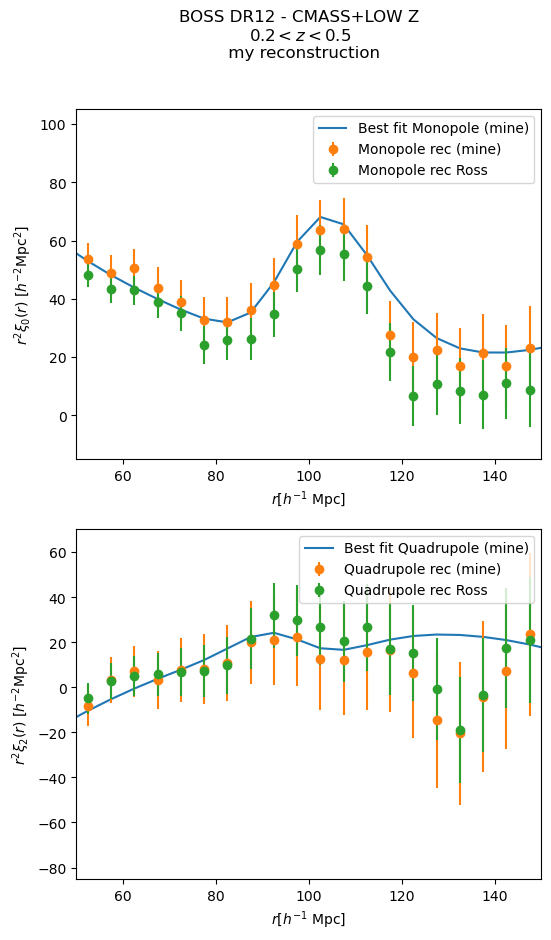

In [105]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

ax1.plot(s, s**2*best_fit_model_z1_rec[0], label='Best fit Monopole (mine)')
ax1.errorbar(s, s**2*xi_multipoles_rec[0], yerr=r**2*errors_elisa_z1[:40], fmt='o', label='Monopole rec (mine)')
ax1.errorbar(s_ross, s_ross**2*xi_multipoles_ross[0], yerr=s_ross**2*err_mon_ross, fmt='o', label='Monopole rec Ross')
ax1.set_ylabel('Monopole')
ax1.legend()
ax1.set_xlabel(r'$r [h^{-1}\ \text{Mpc}]$')
ax1.set_ylabel(r'$r^2\xi_0(r)\ [h^{-2} \text{Mpc}^2]$')
ax1.set_xlim(50, 150)

ax2.plot(s, s**2*best_fit_model_z1_rec[1], label='Best fit Quadrupole (mine)')
ax2.errorbar(s, s**2*xi_multipoles_rec[1], yerr=s**2*errors_elisa_z1[40:], fmt='o', label='Quadrupole rec (mine)')
ax2.errorbar(s_ross, s_ross**2*xi_multipoles_ross[1], yerr=s_ross**2*err_quad_ross, fmt='o', label='Quadrupole rec Ross')
ax2.set_xlabel('r')
ax2.set_ylabel('Quadrupole')
ax2.legend()
ax2.set_xlabel(r'$r [h^{-1} \ \text{Mpc}]$')
ax2.set_ylabel(r'$r^2\xi_2(r) \ [h^{-2} \text{Mpc}^2]$')
ax2.set_xlim(50, 150)

plt.legend()
fig.suptitle('BOSS DR12 - CMASS+LOW Z \n$0.2<z<0.5$ \n my reconstruction')
plt.show()

### my rec in z3

In [106]:
s_z3, mon_z3, quad_z3, hexad_z3 = np.load('/home/emaragliano/Work/Projects/acc_BOSS_analysis/myBOSS_rec_multipoles_z2.npy')

In [107]:
xi_multipoles_rec_z3 = np.ones((3, len(s_z3)))
xi_multipoles_rec_z3[0, :] = mon_z3
xi_multipoles_rec_z3[1, :] = quad_z3
xi_multipoles_rec_z3 [2, :] = 0

In [108]:
Fit_my_rec_z3 = Fit.BestFit(s_z3, xi_multipoles_rec_z3, ext_cov_claudio_z3, cosmo, space='RedshfitSpace', rectype='rec-iso', sigma_rec=15, ellemax=2, fit_range=[50,150])

considering  2  polynomials
fit-range [50, 150]


In [109]:
BF_pars_rec_z3, BF_errs_rec_z3 = Fit_my_rec_z3.run()

running fit...
modelling ...
shape subcov (40, 40)
init guess is,  dict_keys(['alpha_par', 'alpha_perp', 'bias', 'f', 'Sigma_par', 'Sigma_perp', 'Sigma_s', 'Sigma_rec'])
Best-fit parameters:
({'alpha_par': 0.9724411442485255, 'alpha_perp': 0.9916921714929272, 'bias': 1.9139375055744683, 'f': 0, 'Sigma_par': 0.016837250213443313, 'Sigma_perp': 3.5064582191916918, 'Sigma_s': 0, 'Sigma_rec': 15}, {'b00': -1.186083754581137, 'b01': 6.57121461867806, 'b02': -5.0686413454696115, 'b20': -7.11760540365871, 'b21': 19.666660303589207, 'b22': -9.879782938695463, 'b40': 0.0, 'b41': 0.0, 'b42': 0.0})
Parameter errors:
[2.06444041e-02 1.33510769e-02 1.69861249e-01 1.00018750e+01
 2.52953134e+00 1.91468746e+00 4.55922211e+00 2.79875051e+00
 2.52141708e+00 3.09597129e+01 2.83480183e+00]
chi2_red:
1.2132609083460095


In [110]:
# insert 0 for f: rec-sym fixes it
BF_pars_rec_z3=np.insert(BF_pars_rec_z3, 3, 0)
BF_errs_rec_z3=np.insert(BF_errs_rec_z3, 3, 0)
data = {
    param_names[key]: [BF_pars_rec_z3[i], BF_errs_rec_z3[i]] for i, key in enumerate(param_names)
}

df_rec_z3 = pd.DataFrame(data, index=['Best Fit', 'Error'])
df_rec_z3.round(3)

,$\alpha_\parallel$,$\alpha_\perp$,bias,$f$,$\Sigma_\parallel$,$\Sigma_\perp$,b00,b01,b02,b20,b21,b22
Best Fit,0.972,0.992,1.914,0.0,0.017,3.506,-1.186,6.571,-5.069,-7.118,19.667,-9.880
Error,0.021,0.013,0.170,0.0,10.002,2.530,1.915,4.559,2.799,2.521,30.960,2.835


these results are to be compared with Ross et al. 2017, sec 7.2, tab 5. 
- $\chi^2$/dof is 33/30 = 1.1
- $\alpha_\parallel = 0.962 \pm 0.024$
- $\alpha_\perp = 0.991 \pm 0.015$

In [111]:
best_fit_model_z3_rec = Fit_my_rec_z3.GetModelBF()

/home/emaragliano/miniconda3/lib/python3.11/site-packages/BAOFit/Templates.py:252: ComplexWarning: Casting complex values to real discards the imaginary part
  xi_elle[i]=(2.*elles[i]+1.)/2.*np.trapz(xi_mup_rp*Ll[:, None], x=mus, axis=0,dx=mus[1]-mus[0])


As before, all considering, not so bad. Weird values for the $\Sigma_{\parallel, \perp}$

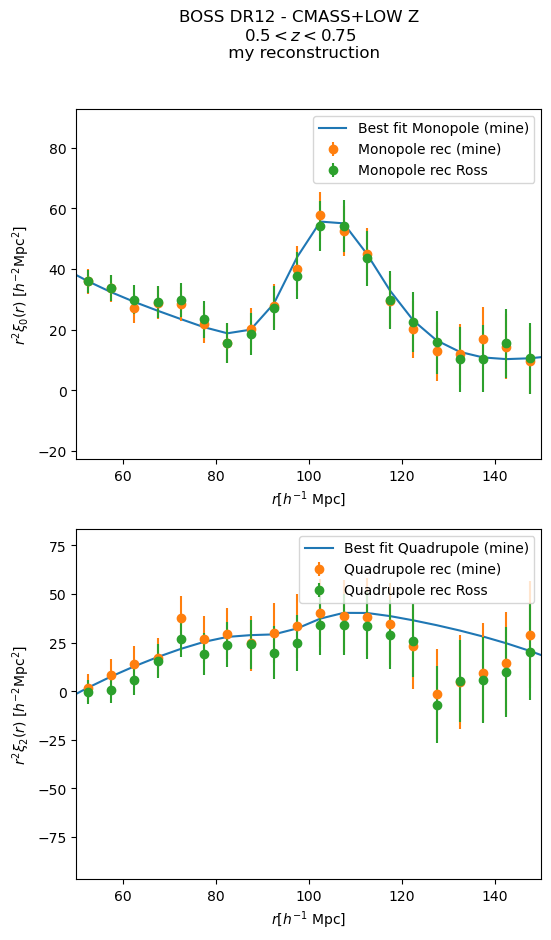

In [112]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 10))

ax1.plot(s, s**2*best_fit_model_z3_rec[0], label='Best fit Monopole (mine)')
ax1.errorbar(s, s**2*xi_multipoles_rec_z3[0], yerr=r**2*errors_elisa_z3[:40], fmt='o', label='Monopole rec (mine)')
ax1.errorbar(s_ross, s_ross**2*xi_multipoles_ross_z3[0], yerr=s_ross**2*err_mon_ross_z3, fmt='o', label='Monopole rec Ross')
ax1.set_ylabel('Monopole')
ax1.legend()
ax1.set_xlabel(r'$r [h^{-1}\ \text{Mpc}]$')
ax1.set_ylabel(r'$r^2\xi_0(r)\ [h^{-2} \text{Mpc}^2]$')
ax1.set_xlim(50, 150)

ax2.plot(s, s**2*best_fit_model_z3_rec[1], label='Best fit Quadrupole (mine)')
ax2.errorbar(s, s**2*xi_multipoles_rec_z3[1], yerr=s**2*errors_elisa_z3[40:], fmt='o', label='Quadrupole rec (mine)')
ax2.errorbar(s_ross, s_ross**2*xi_multipoles_ross_z3[1], yerr=s_ross**2*err_quad_ross_z3, fmt='o', label='Quadrupole rec Ross')
ax2.set_xlabel('r')
ax2.set_ylabel('Quadrupole')
ax2.legend()
ax2.set_xlabel(r'$r [h^{-1} \ \text{Mpc}]$')
ax2.set_ylabel(r'$r^2\xi_2(r) \ [h^{-2} \text{Mpc}^2]$')
ax2.set_xlim(50, 150)

plt.legend()
fig.suptitle('BOSS DR12 - CMASS+LOW Z \n$0.5<z<0.75$ \n my reconstruction')
plt.show()

This plot made me really happy

## Conclusions

Reconstruction was not straightforward. Here are some issues:
1. In Alam et al., it is clarified that they applied the reconstruction at the WHOLE catalogue between z=0.2 and z=0.75, since f and b are almost constant in redshift. They did so in order to avoid problems at big separations. Indeed my rec xi is weird at big r (which I removed because I only plotted the fitting range, but also - in part - to hide the problems xD)
2. I tried to reconstruct the whole catalogue using their values for f and b (Alam et al), split the rec catalogue into two bins and measure the 2PCF. Things got very bad. The monopole was growing after the BAO peak. It might be due to the reshuffling of the total random or to a wrong assessment of the external tidal field or to something I can't even fathom. Who knows.
3. The reconstruction method used in Boss is probably different from the one in ReconChallenge. I use a MultiGridReconstruction. It is not easy to find precise notes about how they implemented the reconstruction. I only found references to a method involving FFT (probably Burden, Percival et al, 2016).
3. To properly estimate the tidal field, the galaxy catalogue should have been put inside a box filled with random galaxies. Then reconstructed, then random galaxy removed. I didn't do it, and this may be why 2PCFs at big r suck. 